In [12]:
# Importer les bibliothèques nécessaires
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
import keras_tuner as kt  # Keras Tuner pour le tuning

In [13]:
# --- Étape 1 : Chargement des données ---
metadata_path = r"C:\Users\marti\Desktop\dom\Data\metadata_f1.csv"
image_dir = r"C:\Users\marti\Desktop\dom\Data"

data = pd.read_csv(metadata_path)
print("Aperçu des données :", data.head())

Aperçu des données :         isic_id diagnosis  age_approx
0  ISIC_0024306     nevus        45.0
1  ISIC_0024307     nevus        50.0
2  ISIC_0024308     nevus        55.0
3  ISIC_0024309     nevus        40.0
4  ISIC_0024310  melanoma        60.0


In [14]:
# --- Step 3: Count Images per Label ---
label_counts = data['diagnosis'].value_counts()
print("\nNumber of images per label:")
print(label_counts)


Number of images per label:
nevus                         7737
pigmented benign keratosis    1338
melanoma                      1305
basal cell carcinoma           622
squamous cell carcinoma        229
vascular lesion                180
dermatofibroma                 160
actinic keratosis              149
Name: diagnosis, dtype: int64


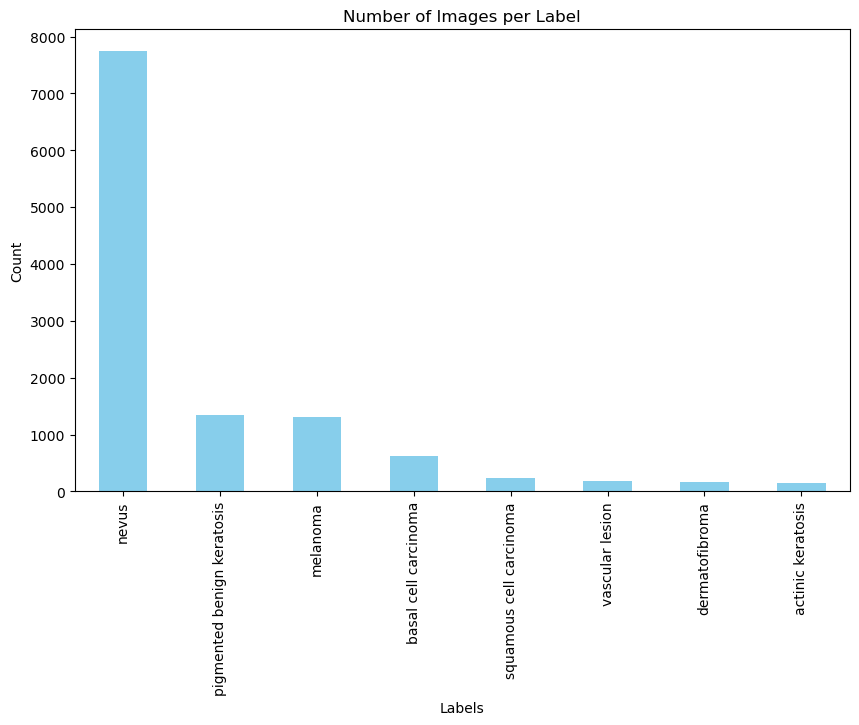

In [15]:

# Plot the counts
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Images per Label')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()



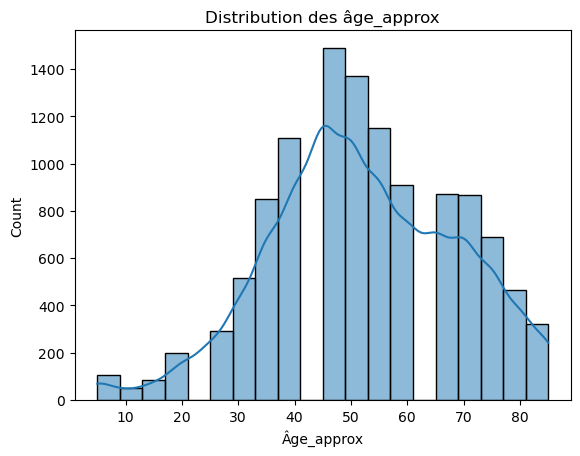

In [16]:
# Distribution des âges
sns.histplot(data['age_approx'], kde=True, bins=20)
plt.title('Distribution des âge_approx')
plt.xlabel('Âge_approx')
plt.show()

In [17]:
print(f"Nombre d'ID uniques : {data['isic_id'].nunique()} sur {len(data)}")


Nombre d'ID uniques : 11720 sur 11720


In [18]:
# Add '.jpg' extension to the 'isic_id' column
data['isic_id'] = data['isic_id'].astype(str) + '.jpg'

# Filter to include only rows with existing image files
data["image_exists"] = data["isic_id"].apply(lambda x: os.path.exists(os.path.join(image_dir, x)))
data = data[data["image_exists"]]


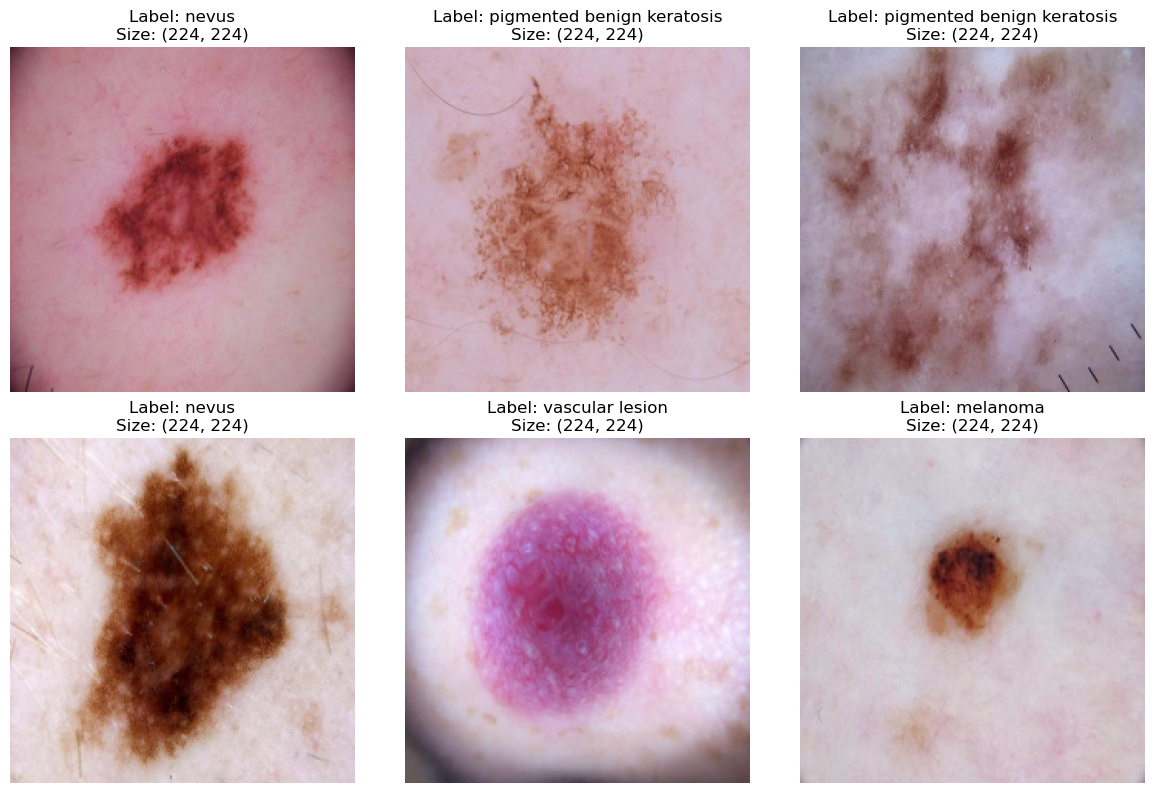

In [19]:
# --- Step 2: Display 6 Images with Labels and Dimensions ---
import matplotlib.image as mpimg
from tensorflow.image import resize

sample_data = data.sample(6)
plt.figure(figsize=(12, 8))
for i, row in enumerate(sample_data.itertuples()):
    image_path = os.path.join(image_dir, f"{row.isic_id}")
    image = mpimg.imread(image_path)
    resized_image = resize(image, (224, 224)).numpy()  # Resize to 224x224
    plt.subplot(2, 3, i + 1)
    plt.imshow(resized_image.astype('uint8'))
    plt.title(f"Label: {row.diagnosis}\nSize: {resized_image.shape[:2]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [21]:
# Encodage des labels
label_mapping = {label: idx for idx, label in enumerate(data['diagnosis'].unique())}
data['encoded_labels'] = data['diagnosis'].map(label_mapping)

# Convertir les labels encodés en chaînes pour éviter l'erreur "TypeError"
data['encoded_labels'] = data['encoded_labels'].astype(str)

In [22]:
# --- Étape 3 : Préparation des données ---
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)
val_gen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

train_generator = train_gen.flow_from_dataframe(
    train_data,
    directory=image_dir,
    x_col='isic_id',
    y_col='encoded_labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_gen.flow_from_dataframe(
    val_data,
    directory=image_dir,
    x_col='isic_id',
    y_col='encoded_labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_gen.flow_from_dataframe(
    test_data,
    directory=image_dir,
    x_col='isic_id',
    y_col='encoded_labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 9376 validated image filenames belonging to 8 classes.
Found 1172 validated image filenames belonging to 8 classes.
Found 1172 validated image filenames belonging to 8 classes.


In [29]:
# --- Étape 4 : Définition du modèle et tuning ---
def build_model(hp):
    # Charger ResNet50 pré-entraîné
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False  # Congeler les poids du modèle pré-entraîné

    # Ajouter des couches personnalisées
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(
        units=hp.Int('units', min_value=128, max_value=512, step=64),
        activation='relu'
    )(x)
    x = layers.Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(x)
    output_layer = layers.Dense(len(label_mapping), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output_layer)

    # Compilation du modèle
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
import json
import pandas as pd
import threading
import time

# Fonction pour lancer la recherche avec un délai
def run_search_with_timeout(tuner, timeout):
    stop_event = threading.Event()
    
    def search():
        try:
            tuner.search(
                train_generator,
                validation_data=val_generator,
                steps_per_epoch=len(train_data) // 32,
                validation_steps=len(val_data) // 32,
                epochs=10
            )
        except Exception as e:
            print(f"Recherche interrompue : {e}")
        finally:
            stop_event.set()
    
    # Lancer la recherche dans un thread séparé
    search_thread = threading.Thread(target=search)
    search_thread.start()
    
    # Attendre la fin du délai ou l'arrêt de la recherche
    search_thread.join(timeout)
    
    if search_thread.is_alive():
        print("Temps limite atteint, arrêt de la recherche.")
        stop_event.set()

# Configurer le tuner Hyperband
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='hyperband_logs',
    project_name='skin_cancer_resnet50',
)

# Lancer la recherche avec une limite de 30 minutes
run_search_with_timeout(tuner, timeout=1800)  # 1800 secondes = 30 minutes

# Obtenir les meilleurs hyperparamètres
try:
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Meilleurs hyperparamètres :\n"
          f"- Units: {best_hps.get('units')}\n"
          f"- Dropout: {best_hps.get('dropout')}\n"
          f"- Optimizer: {best_hps.get('optimizer')}")
    
    # Sauvegarder les meilleurs hyperparamètres dans un fichier JSON
    best_hps_dict = {
        "units": best_hps.get('units'),
        "dropout": best_hps.get('dropout'),
        "optimizer": best_hps.get('optimizer')
    }
    with open('hyperband_logs/best_hyperparameters.json', 'w') as f:
        json.dump(best_hps_dict, f)
    print("Meilleurs hyperparamètres sauvegardés dans 'hyperband_logs/best_hyperparameters.json'.")

    # Obtenir toutes les données des essais
    trials = tuner.oracle.get_best_trials(num_trials=None)  # Obtenir tous les essais
    trial_data = []
    for trial in trials:
        trial_data.append({
            "Trial ID": trial.trial_id,
            "Units": trial.hyperparameters.get('units'),
            "Dropout": trial.hyperparameters.get('dropout'),
            "Optimizer": trial.hyperparameters.get('optimizer'),
            "Final Val Accuracy": trial.score
        })

    # Convertir en DataFrame et afficher sous forme de tableau
    df_trials = pd.DataFrame(trial_data)
    print("\nTableau des essais :")
    print(df_trials)

    # Sauvegarder le tableau des essais dans un fichier CSV
    df_trials.to_csv('hyperband_logs/trials_summary.csv', index=False)
    print("Résumé des essais sauvegardé dans 'hyperband_logs/trials_summary.csv'.")
except Exception as e:
    print(f"Aucune hyperparamètre obtenu en raison de l'interruption : {e}")


Trial 15 Complete [00h 20m 41s]
val_accuracy: 0.6414930820465088

Best val_accuracy So Far: 0.6449652910232544
Total elapsed time: 05h 27m 41s

Search: Running Trial #16

Value             |Best Value So Far |Hyperparameter
384               |512               |units
0.2               |0.4               |dropout
adam              |rmsprop           |optimizer
4                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/4
293/293 [==============================] - 1121s 4s/step - loss: 2.0853 - accuracy: 0.6314 - val_loss: 1.2163 - val_accuracy: 0.6398
Epoch 2/4
293/293 [==============================] - 1152s 4s/step - loss: 1.2227 - accuracy: 0.6649 - val_loss: 1.2324 - val_accuracy: 0.6415
Epoch 3/4
293/293 [==============================] - 1189s 4s/step - loss: 1.2080 - accuracy: 0.6586 - val_loss: 1.1596 - val_accuracy: 0.64

In [38]:
tuner.stop()  # Cela arrête la recherche immédiatement


AttributeError: 'Hyperband' object has no attribute 'stop'

In [ ]:

# --- Étape 5 : Entraînement du meilleur modèle ---
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_data) // 32,
    validation_steps=len(val_data) // 32
)


In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Étape 3 : Afficher la matrice de confusion avec Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prédictions')
plt.ylabel('Véritables')
plt.title('Matrice de Confusion')
plt.show()


NameError: name 'conf_matrix' is not defined

<Figure size 1000x700 with 0 Axes>

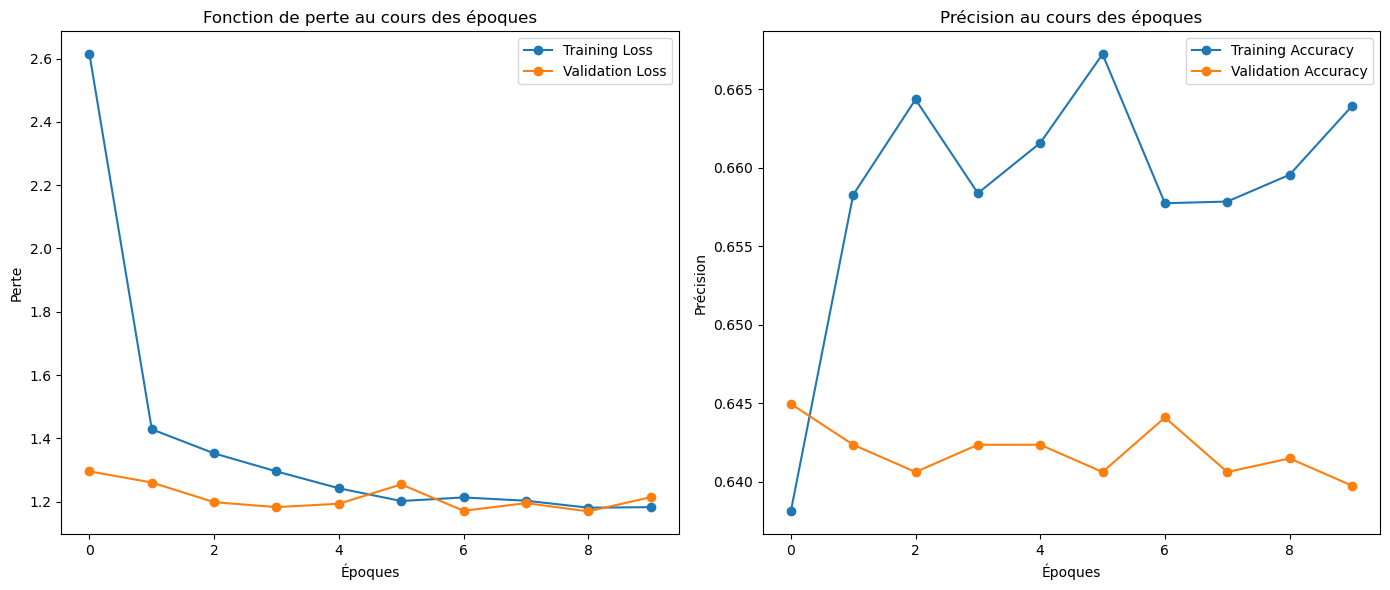

In [40]:
# Visualisation des fonctions de perte et des précisions
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Fonction de perte au cours des époques')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Précision au cours des époques')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.tight_layout()
plt.show()

In [68]:
# --- Étape 7 : Grad-CAM Visualisation ---
def grad_cam(input_model, img_array, layer_name):
    grad_model = Model(
        inputs=[input_model.inputs],
        outputs=[input_model.get_layer(layer_name).output, input_model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)
    guided_grads = tf.cast(conv_outputs > 0, "float32") * grads
    weights = tf.reduce_mean(guided_grads, axis=(0, 1, 2))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)
    return cam

def display_gradcam(image_path, model, layer_name='conv5_block3_out'):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    cam = grad_cam(model, img_array, layer_name)
    cam = tf.maximum(cam, 0) / tf.math.reduce_max(cam)
    cam = tf.image.resize(cam, (224, 224))[0]

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM")
    plt.axis('off')
    plt.show()


In [42]:
# --- Étape 8 : Sauvegarde du modèle ---
# Enregistrer le modèle complet (structure, poids, et état d'entraînement)
best_model.save('skin_cancer_resnet50_best_model.h5')
print("Le modèle a été enregistré sous le nom 'skin_cancer_resnet50_best_model.h5'")


Le modèle a été enregistré sous le nom 'skin_cancer_resnet50_best_model.h5'


In [43]:
# Si vous préférez enregistrer le modèle dans le format SavedModel de TensorFlow
best_model.save('skin_cancer_resnet50_best_model', save_format='tf')
print("Le modèle a été enregistré au format SavedModel sous le nom 'skin_cancer_resnet50_best_model'")

INFO:tensorflow:Assets written to: skin_cancer_resnet50_best_model\assets


INFO:tensorflow:Assets written to: skin_cancer_resnet50_best_model\assets


Le modèle a été enregistré au format SavedModel sous le nom 'skin_cancer_resnet50_best_model'


c:\Users\marti\anaconda3\envs\mat\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
c:\Users\marti\anaconda3\envs\mat\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


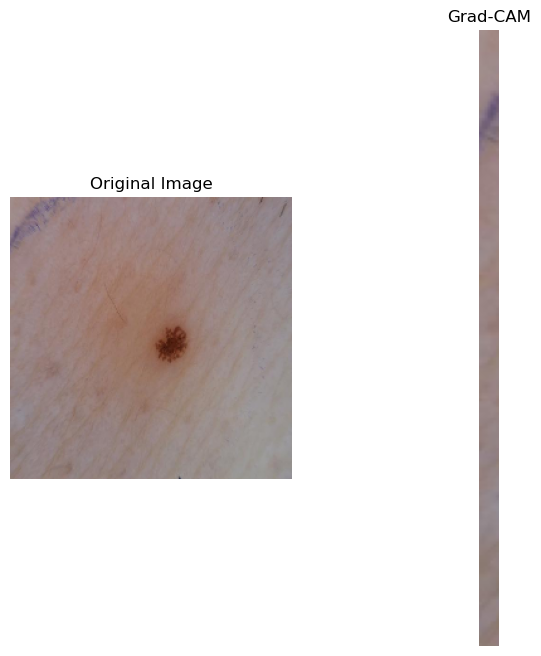

In [44]:
example_image_path = os.path.join(image_dir, test_data.iloc[0]['isic_id'])
display_gradcam(example_image_path, best_model)

Modèle chargé avec succès !
1/1 [==============================] - 3s 3s/step
Probabilités pour chaque label :
nevus: 0.6288
melanoma: 0.1130
pigmented benign keratosis: 0.1118
dermatofibroma: 0.0204
squamous cell carcinoma: 0.0274
basal cell carcinoma: 0.0557
vascular lesion: 0.0221
actinic keratosis: 0.0208
Image prédite : nevus (probabilité: 0.6288)


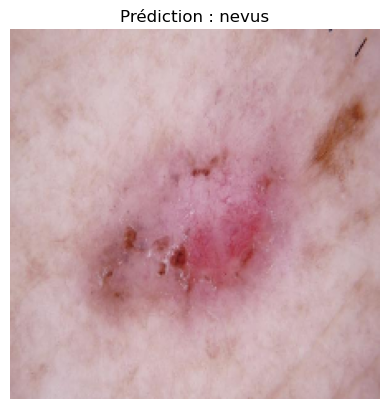

In [69]:
# --- Étape 9 : Chargement du modèle et test sur une image ---
def load_and_predict_image(model_path, image_path):
    # Charger le modèle sauvegardé (assurez-vous que le chemin est correct)
    model = tf.keras.models.load_model(model_path)
    print("Modèle chargé avec succès !")
    
    # Charger l'image, la redimensionner et la prétraiter
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalisation
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour le batch
    
    # Effectuer la prédiction
    predictions = model.predict(img_array)
    
    # Obtenir la classe prédite (index avec la probabilité la plus élevée)
    predicted_class = np.argmax(predictions, axis=1)[0]
    
    # Mapper l'index à l'étiquette
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}
    predicted_label = reverse_label_mapping[predicted_class]
    
    # Afficher les probabilités pour chaque label
    print(f"Probabilités pour chaque label :")
    for i, prob in enumerate(predictions[0]):
        label = reverse_label_mapping[i]
        print(f"{label}: {prob:.4f}")
    
    print(f"Image prédite : {predicted_label} (probabilité: {predictions[0][predicted_class]:.4f})")
    
    return predicted_class, predicted_label, predictions

# Exemple de chemin d'image à tester (remplacer par le chemin de votre image)
test_image_path = r"C:\Users\marti\Desktop\dom\Data\ISIC_0029489.jpg"


# Charger le modèle et tester l'image
model_path = 'skin_cancer_resnet50_best_model.h5'  # ou 'skin_cancer_resnet50_best_model' pour format SavedModel
predicted_class, predicted_label, predictions = load_and_predict_image(model_path, test_image_path)

# Afficher l'image et la prédiction
plt.imshow(tf.keras.preprocessing.image.load_img(test_image_path, target_size=(224, 224)))
plt.title(f"Prédiction : {predicted_label}")
plt.axis('off')
plt.show()
